In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wind-turbine-power-generation-forecasting/column_info.csv
/kaggle/input/wind-turbine-power-generation-forecasting/Train.csv
/kaggle/input/wind-turbine-power-generation-forecasting/Test.csv


In [25]:
!pip install pmdarima

In [26]:
# =============================
# 1. IMPORTS & SEEDS
# =============================

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from prophet import Prophet

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pmdarima as pm
import joblib
import warnings
warnings.filterwarnings("ignore")

# Reproducibility
np.random.seed(42)

In [27]:
# =============================
# LOAD DATASET (KAGGLE PATH)
# =============================

# Load datasets
train_path = "/kaggle/input/wind-turbine-power-generation-forecasting/Train.csv"
test_path  = "/kaggle/input/wind-turbine-power-generation-forecasting/Test.csv"

df = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

print("Train shape:", df.shape)
print("Test shape:", df_test.shape)
df.head()

Train shape: (140160, 12)
Test shape: (35040, 11)


Unnamed: 0              Time  Location  Temp_2m  RelHum_2m      DP_2m  \
0           0  02-01-2013 00:00         1  28.2796  84.664205  24.072595   
1           1  02-01-2013 01:00         1  28.1796  85.664205  24.272595   
2           2  02-01-2013 02:00         1  26.5796  90.664205  24.072595   
3           3  02-01-2013 03:00         1  27.1796  87.664205  23.872595   
4           4  02-01-2013 04:00         1  27.0796  87.664205  23.672595   

     WS_10m   WS_100m      WD_10m     WD_100m    WG_10m     Power  
0  1.605389  1.267799  145.051683  161.057315  1.336515  0.163496  
1  2.225389  3.997799  150.051683  157.057315  4.336515  0.142396  
2  1.465389  2.787799  147.051683  149.057315  3.136515  0.121396  
3  1.465389  2.697799   57.051683  104.057315  1.536515  0.100296  
4  2.635389  4.437799   57.051683   83.057315  3.936515  0.079296

In [28]:
# =============================
# BASIC INSPECTION
# =============================

print("Shape:", df.shape)
df.info()

Shape: (140160, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140160 entries, 0 to 140159
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  140160 non-null  int64  
 1   Time        140160 non-null  object 
 2   Location    140160 non-null  int64  
 3   Temp_2m     140160 non-null  float64
 4   RelHum_2m   140160 non-null  float64
 5   DP_2m       140160 non-null  float64
 6   WS_10m      140160 non-null  float64
 7   WS_100m     140160 non-null  float64
 8   WD_10m      140160 non-null  float64
 9   WD_100m     140160 non-null  float64
 10  WG_10m      140160 non-null  float64
 11  Power       140160 non-null  float64
dtypes: float64(9), int64(2), object(1)
memory usage: 12.8+ MB


In [29]:
# =============================
# MISSING VALUES
# =============================

df.isna().sum()

df.isnull().mean().sort_values(ascending=False)


Unnamed: 0    0.0
Time          0.0
Location      0.0
Temp_2m       0.0
RelHum_2m     0.0
DP_2m         0.0
WS_10m        0.0
WS_100m       0.0
WD_10m        0.0
WD_100m       0.0
WG_10m        0.0
Power         0.0
dtype: float64

In [30]:
# =============================
# DESCRIPTIVE STATISTICS
# =============================

df.describe().T

count          mean           std        min          25%  \
Unnamed: 0  140160.0  17519.500000  10115.212797   0.000000  8759.750000   
Location    140160.0      2.500000      1.118038   1.000000     1.750000   
Temp_2m     140160.0     45.912162     21.930554 -31.420400    29.579600   
RelHum_2m   140160.0     70.420512     17.000203   8.664205    57.664205   
DP_2m       140160.0     35.867228     20.979720 -36.627405    21.172595   
WS_10m      140160.0      4.352948      2.027149   0.165389     2.815389   
WS_100m     140160.0      6.924278      3.056636   0.007799     4.747799   
WD_10m      140160.0    200.684417    100.079917   0.051683   128.051683   
WD_100m     140160.0    200.649010    101.105919  -0.942685   127.057315   
WG_10m      140160.0      8.027673      3.626641   0.436515     5.236515   
Power       140160.0      0.312437      0.253774  -0.000004     0.099696   

                     50%           75%           max  
Unnamed: 0  17519.500000  26279.250000  35039.000000  
Location        2.500000      3.250000      4.000000  
Temp_2m        45.879600     64.579600     94.479600  
RelHum_2m      72.664205     84.664205     99.664205  
DP_2m          35.672595     53.872595     78.272595  
WS_10m          4.055389      5.575389     18.695389  
WS_100m         6.717799      8.847799     24.597799  
WD_10m        211.051683    287.051683    359.051683  
WD_100m       211.057315    289.057315    359.057315  
WG_10m          7.636515     10.236515     28.936515  
Power           0.246896      0.486396      0.988796

In [31]:
# Parse datetime
df["Time"] = pd.to_datetime(df["Time"], dayfirst=True)
df = df.sort_values("Time").reset_index(drop=True)

In [32]:
fig = px.line(df, x="Time", y="Power", title="Wind Power Generation Over Time")
fig.show()

In [33]:
fig = px.histogram(df, x="WS_100m", nbins=50, title="Wind Speed at 100m Distribution")
fig.show()

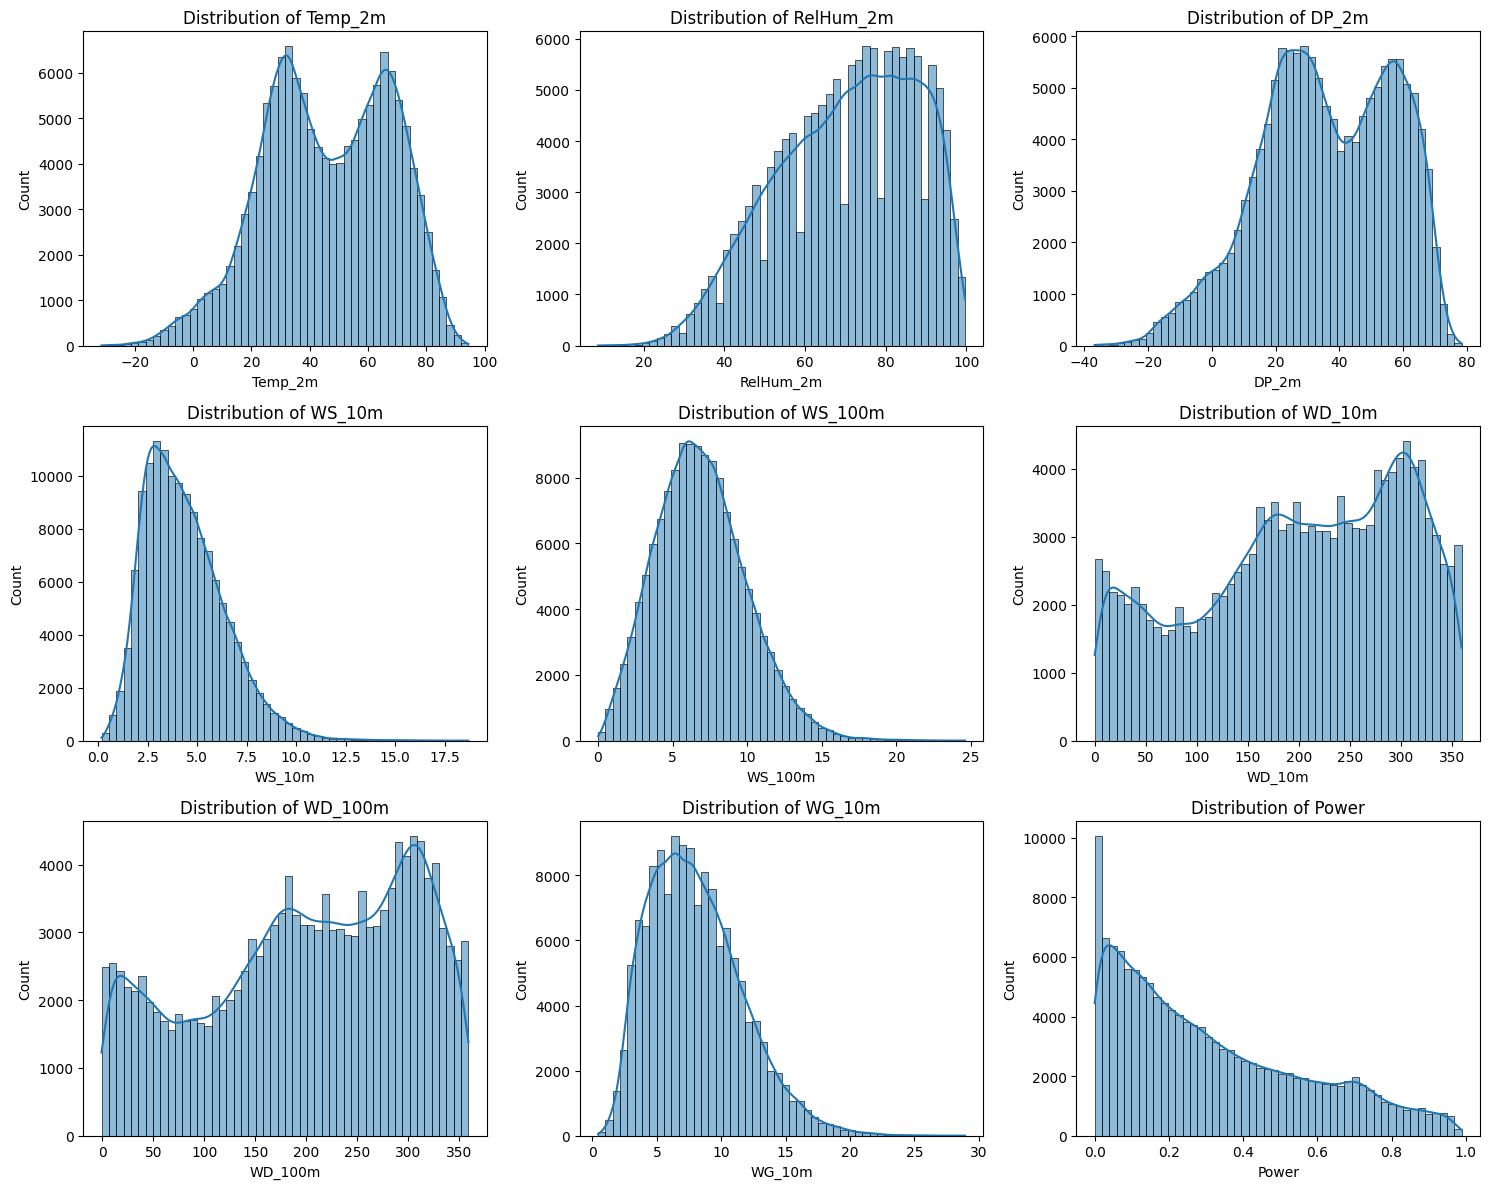

In [37]:
# Distributions of key weather variables
# Why: Check for skewness, strange values, and understand typical ranges.

num_cols = ["Temp_2m", "RelHum_2m", "DP_2m",
            "WS_10m", "WS_100m", "WD_10m", "WD_100m", "WG_10m", "Power"]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


# Unnamed: 0    0.0
# Time          0.0
# Location      0.0
# Temp_2m       0.0
# RelHum_2m     0.0
# DP_2m         0.0
# WS_10m        0.0
# WS_100m       0.0
# WD_10m        0.0
# WD_100m       0.0
# WG_10m        0.0
# Power         0.0

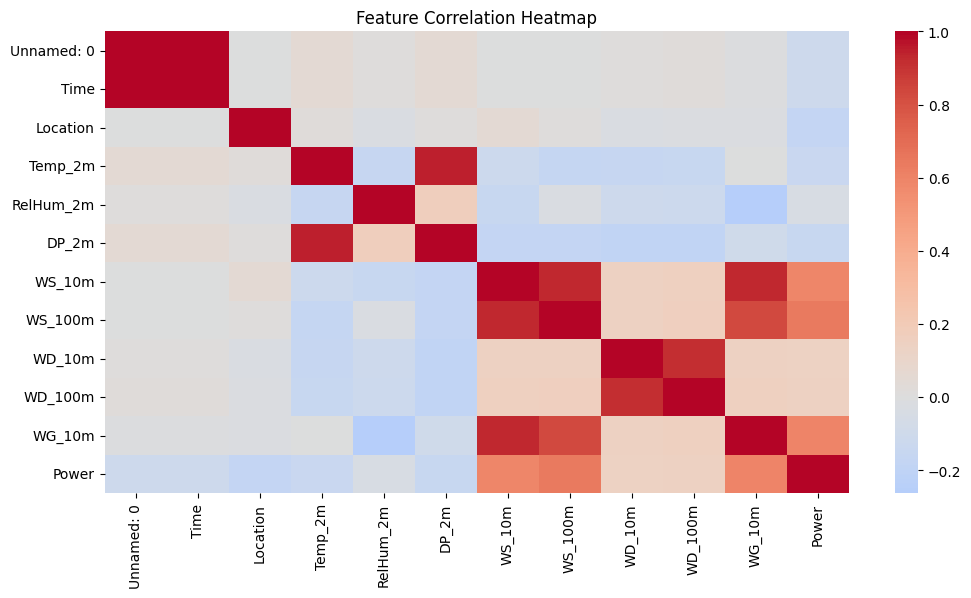

In [38]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [39]:
# Interpolate missing values (time-aware)
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)
df = df.interpolate(method="time")

# Cap extreme values (robust to sensor noise)
for col in ["WS_10m", "WS_100m", "Power"]:
    lower, upper = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(lower, upper)


In [40]:
df["hour"] = df.index.hour
df["day"] = df.index.day
df["month"] = df.index.month
df["weekday"] = df.index.weekday

In [41]:
df["lag_1h"] = df["Power"].shift(1)
df["lag_24h"] = df["Power"].shift(24)

In [42]:
df["rolling_24h"] = df["Power"].rolling(24).mean()
df["rolling_168h"] = df["Power"].rolling(168).mean()

In [43]:
df["wind_energy"] = df["WS_100m"] ** 3
df["wind_direction_effect"] = df["WS_100m"] * np.sin(np.deg2rad(df["WD_100m"]))

In [44]:
df["sin_hour"] = np.sin(2 * np.pi * df["hour"] / 24)
df["cos_hour"] = np.cos(2 * np.pi * df["hour"] / 24)

In [45]:
# Drop NA from lags
df = df.dropna().reset_index(drop=True)

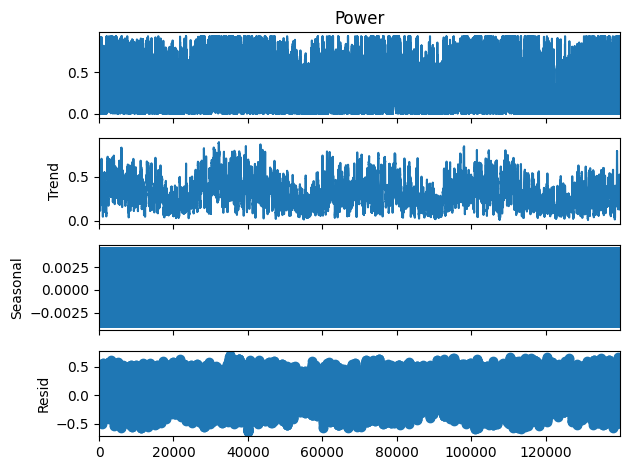

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(
    df["Power"],        # Time index already exists
    model="additive",
    period=24           # hourly data → daily seasonality
)

decomp.plot()
plt.show()


In [47]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df["Power"])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -22.151199223451854
p-value: 0.0


In [48]:
target = "Power"
features = [c for c in df.columns if c not in ["Time", "Power"]]

split_idx = int(len(df) * 0.8)
X_train, X_test = df[features][:split_idx], df[features][split_idx:]
y_train, y_test = df[target][:split_idx], df[target][split_idx:]

In [51]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)


In [53]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)


In [55]:
def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    print(f"{name} | MAE: {mae:.3f}, RMSE: {rmse:.3f}, MAPE: {mape:.2f}%, R2: {r2:.3f}")

# evaluate(y_test, arima_preds, "ARIMA")
evaluate(y_test, lr_preds, "Linear")
# evaluate(y_test, rf_preds, "Random Forest")
evaluate(y_test, xgb_preds, "XGBoost")


Linear | MAE: 0.142, RMSE: 0.035, MAPE: 408000.05%, R2: 0.384
XGBoost | MAE: 0.146, RMSE: 0.041, MAPE: 592518.99%, R2: 0.275


In [56]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=y_test.values, name="Actual"))
fig.add_trace(go.Scatter(y=xgb_preds, name="XGBoost Forecast"))
fig.update_layout(title="Actual vs Predicted Power")
fig.show()


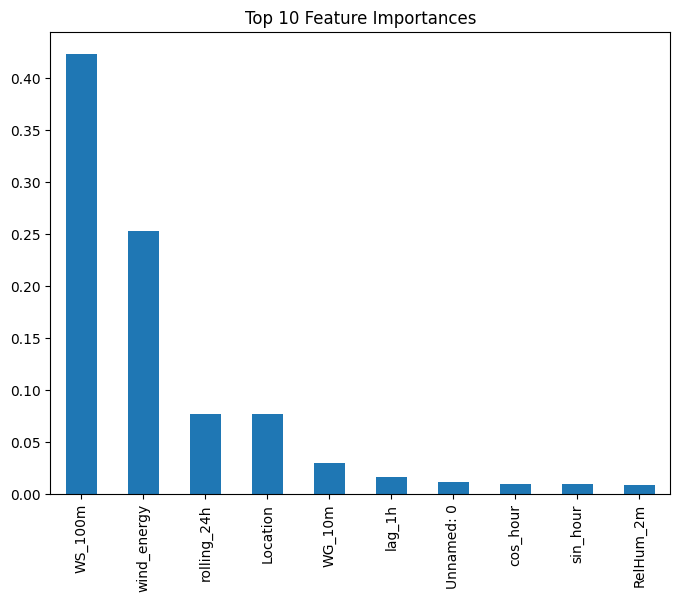

In [57]:
importances = pd.Series(xgb.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(8,6))
importances.head(10).plot(kind="bar")
plt.title("Top 10 Feature Importances")
plt.show()


In [58]:
joblib.dump(xgb, "xgboost_forecast.pkl")
joblib.dump(features, "model_features.pkl")


['model_features.pkl']

In [59]:
def predict_future(input_df, model, feature_cols):
    return model.predict(input_df[feature_cols])
